### 1. [주소 데이터 분석 + 지오맵] 지리 정보 분석 후 맵 생성하기

In [2]:
# ! pip install folium
# *주소를 위도/경도로 변환하는 법: https://wikidocs.net/231323

In [1]:
import folium
import pandas as pd
import webbrowser

In [2]:
# 복사한 좌표를 사용한 지도 객체를 생성
map_osm = folium.Map(location = [37.55987, 126.9752], zoom_start=16)
map_osm.save('map.html') 

# 지도에 매장 위치 표시하기
CB_geoData = pd.read_csv('CB_geo_sph_2.csv', encoding ='UTF8', engine = 'python')
map_CB = folium.Map(location = [37.55987, 126.9752], zoom_start = 15)

for i, store in CB_geoData.iterrows():
    folium.Marker(location=[store['_Y'],store['_X']], popup=store['store']
                  ,icon=folium.Icon(color='red',icon='star')).add_to(map_CB) # Icon 대문자임

map_CB.save('map_CB.html')
webbrowser.open('map_CB.html')

True

In [5]:
# %history -g
# ?.ipynb파일 셀이 갑자기 저장이 안되고, 날라가는 경우 histroy로 찾아서 다시 내용 복붙해오면 됨!

# [행정구역별 데이터 분석 + 블록맵] 행정구역별 의료기관 현황분석하기

## Step0: 데이터 준비 및 탐색

### 1. 공공보건의료기관 현황 데이터 준비하기

In [6]:
import numpy as np
import pandas as pd
# error, warning 무시 --> 경고 끔
pd.set_option('mode.chained_assignment', None)

### (1)데이터 파일 확인
data = pd.read_csv('공공보건의료기관현황.csv', index_col=0,
                   encoding='CP949', engine='python')
data.head()

### (2)주소 정리 - 주소에서 시도, 군구 정보 분리
  # ex): 강원도 춘천시 충열로 142번길 24-16
  # 주소정보만 뽑아낼건데, 그걸 또 apply-lambda로 가공!
    # 시군과 군구 정보에 해당하는 0~1번 컬럼[:2]을 추출해서 컬럼 이름을 ‘시도’, ‘군구’로 나타내고,
    # columns=(' 시도', '군구'), 데이터프레임 객체인 addr을 생성
addr = pd.DataFrame(data['주소'].apply(lambda v: v.split()[:2]).tolist(),columns=('시도','군구'))
addr.head()


### (3)시도 이름에서 잘못된 내용이 있는지 확인
addr['시도'].unique()
# 길이 체크하고 싶으면? = 몇개 요소가 있는지 보고 싶으면
len(addr['시도'].unique()) # 29

### (4)잘못된 위치를 찾아서 값을 수정(창원시,경산시,천안시)
addr[addr['시도'] == '창원시']
addr.iloc[27] = ['경상남도', '창원시']
addr.iloc[31] = ['경상남도', '창원시']

addr[addr['시도']=='경산시']
addr.iloc[47] = ['경상남도', '경산시'] 

addr[addr['시도'] == '천안시'] 
addr.iloc[209] = ['충청남도', '천안시']
addr.iloc[210] = ['충청남도', '천안시']

### (6)다시 addr 객체의 [‘시도’] 컬럼 값에서 수정할 내용이 있는지 확인
addr['시도'].unique()

### (7)‘경기’, ‘경남’과 같이 축약된 이름을 정확한 표준 이름으로 수정
addr_aliases = {'경기':'경기도', '경남':'경상남도', '경북':'경상북도', '충북':'충청북도', '서울시':'서울특별시',
                '부산특별시': '부산광역시', '대전시':'대전광역시', '충남':'충청남도', '전남':'전라남도', '전북':'전라북도'}
addr['시도'] = addr['시도'].apply(lambda v: addr_aliases.get(v, v)) # ? 함수 사용법 - get

addr['시도'].unique() # 체크

### (8)[‘군구’] 컬럼에서 정리할 사항이 있는지 탐색 및 정리
addr['군구'].unique()
addr[addr['군구'] == '아란13길']
addr.iloc[75] = ['제주특별시', '제주시']


### *(9)행정구역별 공공보건의료기관의 수 구하기
addr['시도군구'] = addr.apply(lambda v: v['시도'] + ' ' + v['군구'], axis=1)
addr['count'] = 0 # 모든 행의 count컬럼이 다 0으로 초기화

# ? 이렇게 하네 어렵네.. groupby & count
addr_group = pd.DataFrame(addr.groupby(['시도', '군구', '시도군구'], as_index=False).count())
addr_group

### (10)데이터 병합에 사용할 인덱스를 설정 - 현재는 0,1,2,..자동idx임
  # '시도군구'를 index로 지정할 것
  # set_index(key)함수 쓰면 되네
addr_group = addr_group.set_index('시도군구')
addr_group

,시도,군구,count
시도군구,,,
강원도 강릉시,강원도,강릉시,4
강원도 동해시,강원도,동해시,1
강원도 삼척시,강원도,삼척시,1
강원도 속초시,강원도,속초시,1
강원도 양구군,강원도,양구군,1
...,...,...,...
충청북도 영동군,충청북도,영동군,1
충청북도 제천시,충청북도,제천시,1
충청북도 청원군,충청북도,청원군,1


### 2. 행정구역별 인구수 데이터 준비하기

In [7]:
### (1)데이터 정리하기
    # *csv파일 vs excel파일인지 확인하고 read돌리기 -> 무지성 read_csv ;;;;;
population = pd.read_excel('행정구역인구수.xlsx')
population.head()

# rename()함수를 사용하여 컬럼 이름을 변경!!
population = population.rename(columns={'행정구역(시군구)별(1)': '시도',
                                        '행정구역(시군구)별(2)': '군구'})
population.head()

### (2)[‘군구’] 컬럼에 포함되어 있는 왼쪽 띄어쓰기 공백을 제거

# ? 이 과정을 한꺼번에 한 줄로 하는 건 없나 - strip은 series에는 안되서 popluation['군구'].strip()이 안되긴 하는데
for element in range(0,len(population)):
    # population['군구'][element] = population['군구'][element].strip() # 이건 옛날 방식
    # -> df.loc[row_indexer, 'column명']!
    population.loc[element, '군구'] = population.loc[element, '군구'].strip() # 이게 최신

### (2-2)[‘시도군구’] 컬럼을 만들고 addr_group과 병합하기 위해 인덱스로 설정
population['시도군구'] = population.apply(lambda v: v['시도'] + ' ' + v['군구'], axis=1) # axis=1!
population = population[population.군구 != '소계'] # '소계'는 제거 - where느낌

population = population.set_index('시도군구')
population.head()

### todo (3)addr_group과 population을 인덱스 기준으로 병합 -> 두 테이블 Join! - 중요
    # 필요한 데이터를 하나의 데이터프레임으로 정리할 수 있다
    # pd.merge 함수 - https://yganalyst.github.io/data_handling/Pd_12/
    # join하면, 컬럼이 시도,군구 -> 시도_x, 시도_y이런식으로 바뀌네 ㄷㄷ;
# ? 아래 함수 머임? inner조인하고, left,right index 다 true는 무슨뜻이고?
addr_population_merge = pd.merge(addr_group,population, how='inner'
                                 ,left_index = True, right_index = True)
addr_population_merge.head()

local_MC_Population = addr_population_merge[['시도_x', '군구_x','count', '총인구수 (명)']]
local_MC_Population.head()

#컬럼 이름 변경
local_MC_Population = local_MC_Population.rename(columns = {'시도_x': '시도',
                                                            '군구_x': '군구','총인구수 (명)': '인구수'})

MC_count = local_MC_Population['count']
# 각 행정구역 별 인구수 대비, 의료기관 비율
    # div함수 - pandas에서 비율 구할 때 나누기함수인가봄ㅇㅇ
local_MC_Population['MC_ratio'] = MC_count.div(local_MC_Population['인구수'], axis=0) * 100000

## Step1: 분석 모델 구축 및 시각화

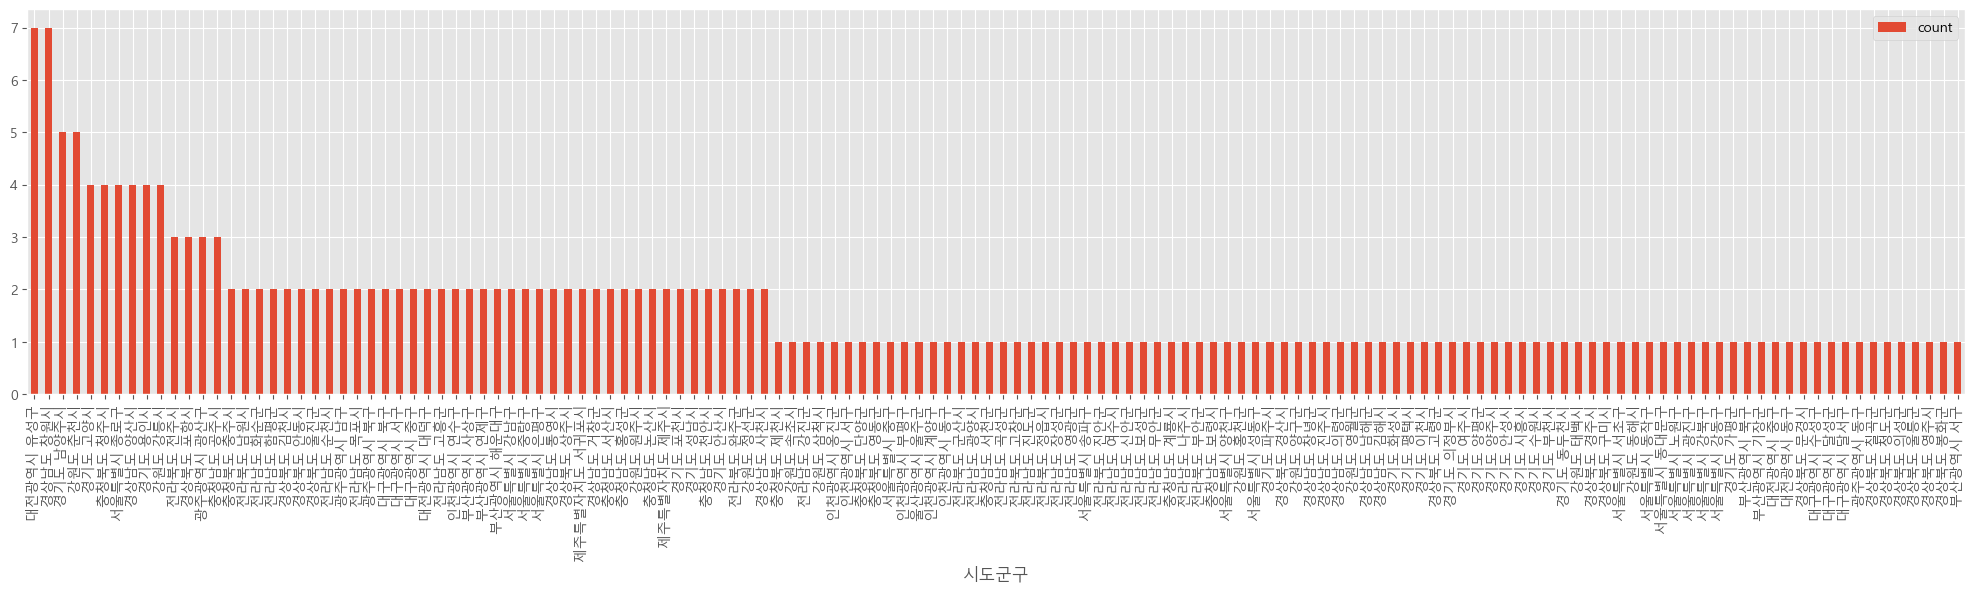

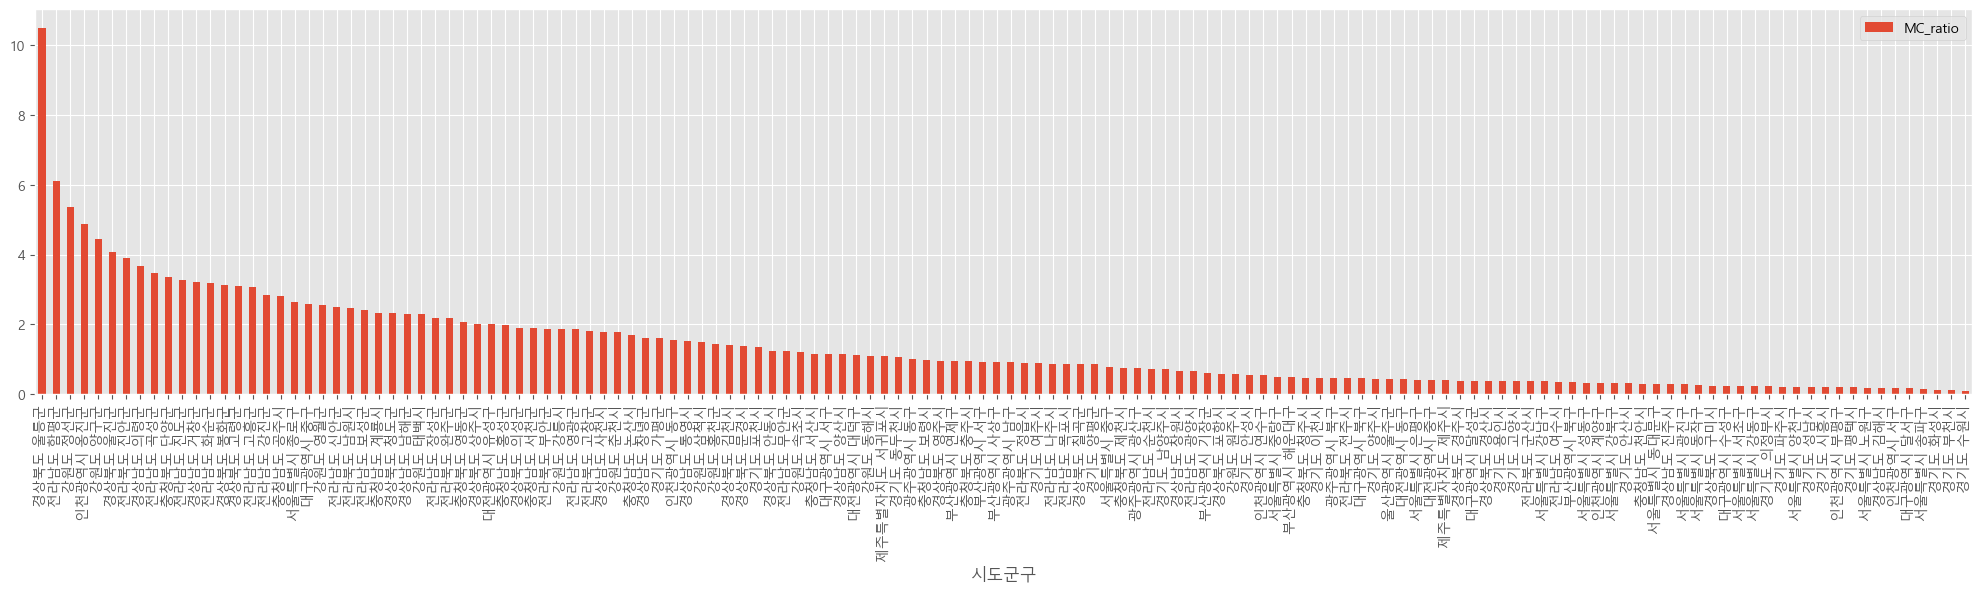

In [8]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)

# (1)행정구역별 공공보건의료기관 수에 대한 바 차트를 그리기
MC_ratio = local_MC_Population[['count']]
MC_ratio = MC_ratio.sort_values('count', ascending = False)
plt.rcParams["figure.figsize"] = (25, 5)
MC_ratio.plot(kind = 'bar', rot = 90)
plt.show()

# (2)행정구역별로 인구수 대비 공공보건의료기관 비율에 대한 바 차트를 그리기
MC_ratio = local_MC_Population[['MC_ratio']]
MC_ratio = MC_ratio.sort_values('MC_ratio', ascending = False)
plt.rcParams["figure.figsize"] = (25, 5)
MC_ratio.plot(kind = 'bar', rot = 90)
plt.show()

In [9]:
# (3)볼록맵으로 시각화하기 - data_draw_korea.csv
import os
path = os.getcwd() # 현재 사용 중인 폴더(디렉토리)의 경로를 구하여 path에 저장

data_draw_korea = pd.read_csv(path+'\\data_draw_korea.csv',index_col = 0, encoding = 'UTF-8', engine = 'python')
data_draw_korea.head()

data_draw_korea['시도군구'] = data_draw_korea.apply(lambda r: r['광역시도'] + ' ' + r['행정구역'], axis=1)
data_draw_korea = data_draw_korea.set_index('시도군구')

data_draw_korea_MC_Population_all = pd.merge(data_draw_korea,local_MC_Population, how = 'outer',
                                             left_index = True, right_index = True)
data_draw_korea_MC_Population_all.head()

# 블록맵의 행정구역 경계선을 그리기 위해 행정구역의 블록 위치인 x, y 데이터를 정의
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]


In [14]:
data_draw_korea_MC_Population_all['시도'].unique()

array(['강원도', nan, '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시',
       '부산광역시', '서울특별시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도',
       '충청남도', '충청북도'], dtype=object)

In [11]:
# 블록맵의 블록에 데이터를 매핑하고 색을 표시하여 블록맵을 그린 뒤 저장하는 함수를 정의
def draw_blockMap(blockedMap, targetData, title, color ):
    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData])) * 0.25 + min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(8, 13))
    plt.title(title)
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=color, edgecolor='#aaaaaa', linewidth=0.5)

    # 0. 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
    
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if row['광역시도'].endswith('시') and not row['광역시도'].startswith('세종'):
            dispname = '{}\n{}'.format(row['광역시도'][:2], row['행정구역'][:-1])
            if len(row['행정구역']) <= 2:
                dispname += row['행정구역'][-1]
        else:
            dispname = row['행정구역'][:-1]

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 9.5, 1.5
        else:
            fontsize, linespacing = 11, 1.2

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)
    
    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=4)

    plt.gca().invert_yaxis()
    #plt.gca().set_aspect(1)
    plt.axis('off')
    
    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    
    plt.savefig('.\\' + 'blockMap_' + targetData + '.png')

    plt.show()      

C:\Users\A\AppData\Local\Temp\ipykernel_6628\2768210598.py:48: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(shrink=.1, aspect=10)


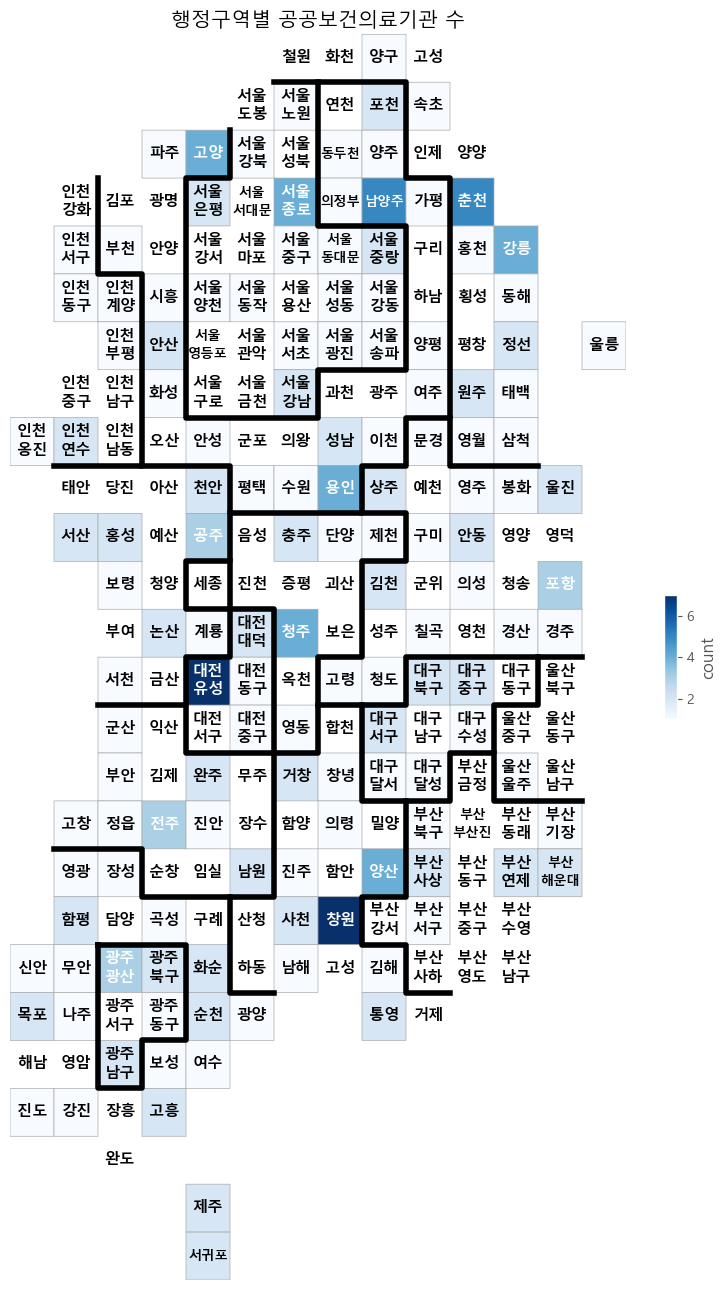

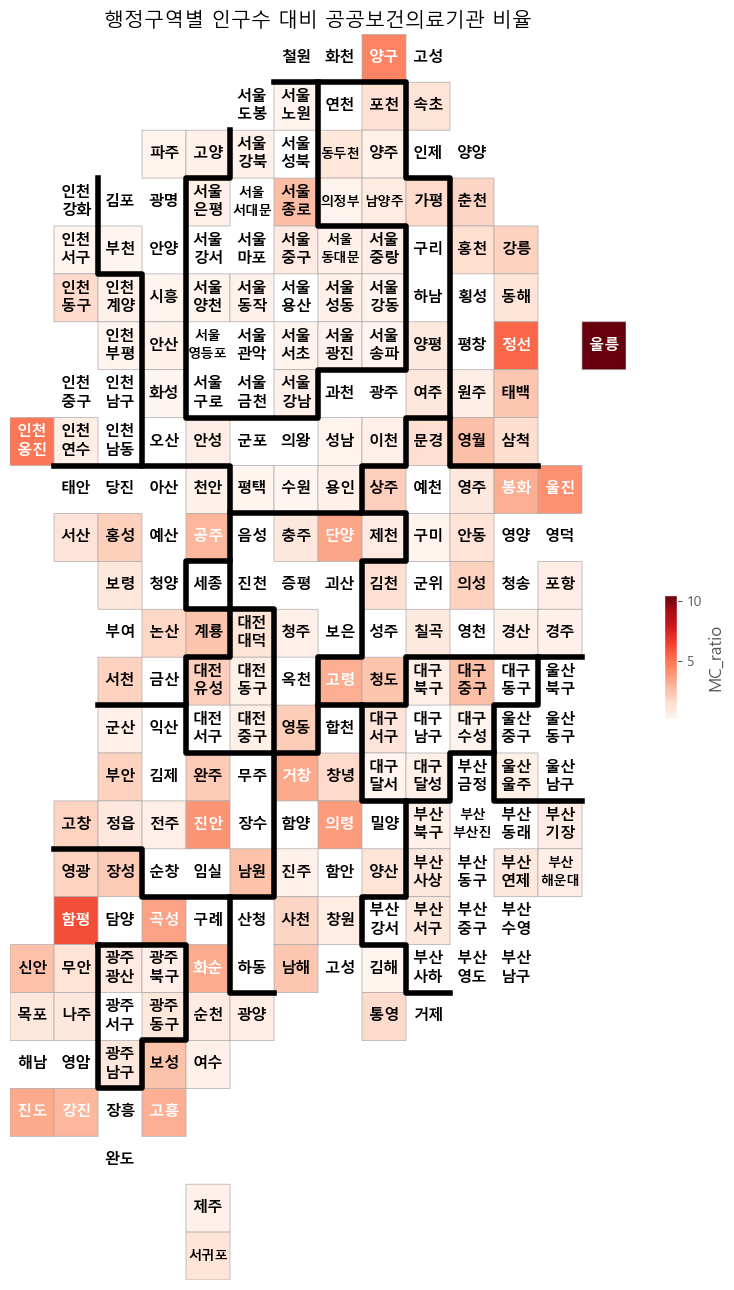

In [12]:
# 행정구역별 공공보건의료기관 수를 블록맵으로 시각화
draw_blockMap(data_draw_korea_MC_Population_all, 'count', '행정구역별 공공보건의료기관 수', 'Blues')
# 인구수 대비 공공보건의료기관 비율을 블록맵으로 시각화
draw_blockMap(data_draw_korea_MC_Population_all, 'MC_ratio', '행정구역별 인구수 대비 공공보건의료기관 비율', 'Reds')